In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import cvxpy as cp
from numpy import linalg as LA
import pprint
from lap import lapjv
import copy
import sys
import datetime
from tqdm import tqdm_notebook

print(sys.getrecursionlimit())
sys.setrecursionlimit(20000)

ro = np.linspace(0,1,25)
n = 35
k = 5

a = 0.2
 
num_loop = 5000


3000


In [2]:
# Construct K
def K_Bernoulli(n,a):
    np.random.seed(3)
    K=np.identity(n)
    P=np.ones([n,n]) 
    K = P-K
    #print(K)
    for i in range(n):
        for j in range(i+1,n):
            K[i][j] = round(random.uniform(a,1-a),2)
            #K[i][j] = random.uniform(alpha,1-alpha)
            K[j][i]=K[i][j]        
    return K
     

# Generate A
def A_adj(K):
    n = len(K)
    B=np.identity(len(K))
    P=np.ones([n,n]) 
    #print(P)
    B= P-B
    #print(B)
    for i in range(len(B)):
        for j in range(i+1,len(B)):
            B[i][j] =random.uniform(0,1)
            if B[i][j] < K[i][j]:
                B[i][j] = 1
            else:
                B[i][j] = 0
            B[j][i] = B[i][j]
    A = B
    return A

# Generate B
def B_adj(ro,K,A):
    B = np.zeros([len(A),len(A)])
    for i in range(len(B)):
        for j in range(i+1,len(B)):
            B[i][j] =random.uniform(0,1)
            if B[i][j] < (1-ro)*K[i][j] + ro*A[i][j]:
                B[i][j] = 1
            else:
                B[i][j] = 0
            B[j][i] = B[i][j]
    return B
    
    
                
            
                
            


In [3]:
#Construct a n-degree permutation matrix 

def permu(N):
    E=np.identity(N)
    permutation = np.random.permutation(N)
    P=np.zeros([N,N]) #initialize the permutation matrix
     
    for i in range(0,N):
        P[i]=E[permutation[i]]
    
    
    return P.astype(int)


In [4]:
# Generate a random aj matrix for unweighted and undirected graph
def generate_aj_matrix(n):
    id = np.identity(n)
    ones_mat=np.ones((n, n)) 
    arr = ones_mat - id
    #print(arr)
    for i in range(n):
        for j in range(i+1,n):
            arr[i][j] = random.choice([0,1])
            arr[j][i] = arr[i][j]
    return arr

In [5]:
def ret_permu_result(l,n):
    ret = np.zeros((n, n))
    for i in range(n):
        ret[i][l[i]] = 1
    #print(ret)
    return ret

In [6]:


one_arr = np.ones((n, 1))
initial = one_arr@one_arr.T / n



In [7]:
def f_for_step_3(A,B,P):
    return -np.trace(A@P@B.T@P.T)

In [8]:
def get_alpha_value(A,B,P,Q):
    alpha = 0
    a = -np.trace(A@P@B.T@P.T-A@P@B.T@Q.T-A@Q@B.T@P.T+A@Q@B.T@Q.T)
    b  = np.trace(2*(A@P@B.T@P.T)-A@P@B.T@Q.T-A@Q@B.T@P.T)
    x_extreme = -b/(2*a)
    dic = dict()
    dic[0] = f_for_step_3(A,B,P)
    dic[1]=f_for_step_3(A,B,Q)
    dic[x_extreme] = f_for_step_3(A,B,(1-x_extreme)*P+x_extreme*Q)
    
    #print(dic)
    if (x_extreme < 1) and (x_extreme>0):    
        Min = dic[0]
        key = 0
        for k, v in dic.items():
            if v < Min:
                #print(key, Min)
                #print(k,v)
                #print(v < Min)
                key = k
                Min = v
        #print(key)
        return key
    else:
        
        Min = dic[0]
        if dic[1]<Min:
            Min = dic[1]
            #print(1)
            return 1
        #print(0)
        return 0 
        

    

In [9]:
def loss_P_1_percent(P_D_r,P_1):
    loss = 0
    for i in (P_D_r==P_1):
        for j in i:
            if j == False:
                loss +=1
    loss = loss/2
    loss_percent = loss/n
    return loss_percent

In [10]:
def FAQ(n,A,B,initial,eps,loop,num_loop):
    loop += 1
    # Compute gradient
    gradient = -A@initial@B.T - A.T@initial@B
    
    x,y,c = lapjv(gradient)
    index_list = y
    Q = ret_permu_result(index_list,n)
    
    
    # Update P
    alpha = get_alpha_value(A,B,initial,Q)
    #print(alpha)
    P_new = (1-alpha)*initial + alpha*Q
    #P_new = initial + alpha*Q
    
    
    if loop>num_loop:
        # Projection
        e,r,t = lapjv(-P_new.T)
        #print(r)
        P_result = ret_permu_result(r,n).T
        return P_result

    if LA.norm(P_new-initial, 'fro') < eps:
        # Projection
        e,r,t = lapjv(-P_new.T)
        #print(r)
        P_result = ret_permu_result(r,n).T
        #print("norm close\n",P_result)
        return P_result
    else:
        return FAQ(n,A,B,P_new,eps,loop,num_loop) 
    #print(P_new)

In [11]:

def initialization_J(A,B,n,initial,num_loop):
    P_1 = np.identity(n)
    P_r = FAQ(n,A,B,initial,10**(-9),0,num_loop)
    loss = 0
    for i in (P_r==P_1):
        for j in i:
            if j == False:
                loss +=1
    loss = loss/2
    loss_percent = loss/n
    align_percent = 1- loss_percent
    
    return align_percent



In [12]:


def initialization_D(A,B,n,num_loop):
    # check if the same as cvxpy
    # Define and solve the CVXPY problem.
    P_1 = np.identity(n)
    P = cp.Variable((n,n))
    arr = cp.expressions.constants.Constant([[1 for i in range(n)]])
    constraints = [P.__matmul__(arr) == arr, P.T.__matmul__(arr) == arr, cp.min(P)>=0]
    prob = cp.Problem(cp.Minimize((cp.norm(P.__matmul__(B)-(P.T.__matmul__(A.T)).T, 'fro'))**2), constraints)
    # prob = cp.Problem(cp.Minimize(LA.norm(np.multiply(P,A)-np.matmul(B,P), 'fro')), constraints)
    prob.solve()

    initial_D = P.value
    P_D_r = FAQ(n,A,B,initial_D,10**(-9),0,num_loop)
    loss = 0
    for i in (P_D_r==P_1):
        for j in i:
            if j == False:
                loss +=1
    loss = loss/2
    loss_percent = loss/n
    align_percent = 1- loss_percent
    #print(loss_percent)
    return align_percent


In [13]:
def J_D_comparison(ro,alpha,n,k,num_loop):
    sum_align_J = 0
    sum_align_D = 0
    for i in range(k):
        P_1 = np.identity(n)
        K= K_Bernoulli(n,alpha)
        A = A_adj(K)
        B_ori = B_adj(ro,K,A)
        B = np.matmul(P_1.T, np.matmul(B_ori,P_1))
        sum_align_D +=initialization_D(A,B,n,num_loop)
        sum_align_J +=initialization_J(A,B,n,initial,num_loop)
    
    avg_align_J = sum_align_J / k
    avg_align_D = sum_align_D / k
    #print(avg_align)
    return avg_align_J, avg_align_D
    
        


In [14]:
J_aligned_percent_list = []
D_aligned_percent_list = []

for i in tqdm_notebook(range(len(ro))):
    
    J_avg,D_avg = J_D_comparison(ro[i],a,n,k,num_loop)
    print(J_avg,D_avg)
    J_aligned_percent_list.append(J_avg)
    D_aligned_percent_list.append(D_avg)
    

<ipython-input-14-6013648394cc>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ro))):


<ipython-input-8-9c6fdf298a1d>:5: RuntimeWarning: divide by zero encountered in double_scalars
  x_extreme = -b/(2*a)
<ipython-input-8-9c6fdf298a1d>:9: RuntimeWarning: invalid value encountered in multiply
  dic[x_extreme] = f_for_step_3(A,B,(1-x_extreme)*P+x_extreme*Q)
<ipython-input-8-9c6fdf298a1d>:9: RuntimeWarning: invalid value encountered in add
  dic[x_extreme] = f_for_step_3(A,B,(1-x_extreme)*P+x_extreme*Q)
<ipython-input-8-9c6fdf298a1d>:5: RuntimeWarning: invalid value encountered in double_scalars
  x_extreme = -b/(2*a)


0.017142857142857147 0.011428571428571432
0.02857142857142858 0.02857142857142858
0.034285714285714294 0.034285714285714294
0.040000000000000015 0.040000000000000015
0.034285714285714294 0.04571428571428571
0.022857142857142864 0.034285714285714294
0.04571428571428573 0.04571428571428573
0.034285714285714294 0.04571428571428573
0.034285714285714294 0.017142857142857147
0.005714285714285716 0.04571428571428573
0.10285714285714287 0.09714285714285717
0.06285714285714288 0.05142857142857145
0.034285714285714294 0.011428571428571432
0.06857142857142859 0.09142857142857141
0.08571428571428572 0.12000000000000002
0.05142857142857145 0.21142857142857147
0.10285714285714287 0.6857142857142857
0.04571428571428573 0.49714285714285716
0.08000000000000003 0.9428571428571428
0.14285714285714285 1.0
0.09142857142857146 1.0
0.2628571428571429 1.0
0.2514285714285715 1.0
0.5542857142857143 1.0
1.0 1.0



In [15]:
print(J_aligned_percent_list)
print(D_aligned_percent_list)

[0.017142857142857147, 0.02857142857142858, 0.034285714285714294, 0.040000000000000015, 0.034285714285714294, 0.022857142857142864, 0.04571428571428573, 0.034285714285714294, 0.034285714285714294, 0.005714285714285716, 0.10285714285714287, 0.06285714285714288, 0.034285714285714294, 0.06857142857142859, 0.08571428571428572, 0.05142857142857145, 0.10285714285714287, 0.04571428571428573, 0.08000000000000003, 0.14285714285714285, 0.09142857142857146, 0.2628571428571429, 0.2514285714285715, 0.5542857142857143, 1.0]
[0.011428571428571432, 0.02857142857142858, 0.034285714285714294, 0.040000000000000015, 0.04571428571428571, 0.034285714285714294, 0.04571428571428573, 0.04571428571428573, 0.017142857142857147, 0.04571428571428573, 0.09714285714285717, 0.05142857142857145, 0.011428571428571432, 0.09142857142857141, 0.12000000000000002, 0.21142857142857147, 0.6857142857142857, 0.49714285714285716, 0.9428571428571428, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


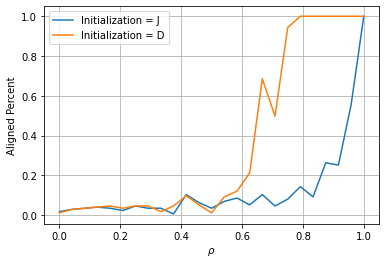

In [16]:

plt.plot(ro, J_aligned_percent_list,label="Initialization = J")
plt.plot(ro, D_aligned_percent_list, label="Initialization = D")
plt.xlabel(r'$\rho$')
plt.ylabel('Aligned Percent')
plt.grid()
plt.legend()
#plt.show()
#plt.close()
plt.savefig('a = 0.2 n=50 trace_initialization_comparison.eps', dpi=500)